Facebook: Evaluating the Interactions to Post Type and Post Day

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(dbplyr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Introduction:

* Provide some relevant background information on the topic so that someone unfamiliar with it will be prepared to understand the rest of your proposal
> * The data used originated from the Facebook metrics of a popular cosmetics brand. Based on this information, we want to know how successful each post type is based on its audience reach. We will base the sucess of each post by the total number of interactions (likes, comments, shares).
> * We have decided to use the total number of interactions on posts rather than the total amount of times a post has been consumed. This is to determine how much of each post type have the highest engagement/ active users. This is because the number of people viewing a specific post can be misleading because people could be accidently clicking on the post which still counts as 1 view. We want to see the actively viewing/participating users who actually intended on viewing the post. 
* Clearly state the question you will try to answer with your project
> * Which kind of post (link, photo, status or video) is most popular during each day?
In answering the above question we will also think about: which post type is most popular in general? Which day do people interact on facebook the most on?
* Identify and describe the dataset that will be used to answer the question
> * The data set used to answer the question is dataset_Facebook.csv. From the data, the x-axis is the "Total Interaction Count" while the y-axis is the "Weekday Posted." The fill of the bars is the type of post being interacted with. We will use this data to answer the question by finding what kind of post and which day to post is the most popular has the highest value.

Preliminary exploratory data analysis:
- Demonstrate that the dataset can be read from the web into R 
- Clean and wrangle your data into a tidy format

In [2]:
activity_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip" #ICS Machine Learning Training set archive      
temp <- tempfile()                       #Vector of character strings to be used for naming temporary files, saved to temp.
download.file(activity_url, temp)        #Download Zip file from ICS archive, save into temp.
unzip(temp, "dataset_Facebook.csv")      #Unzip File.


fb_data <- read_delim("dataset_Facebook.csv",  #Read dataset and factor Type Column
                      ";") %>%                     
    mutate(Type = as.factor(Type))

unlink(temp)                            #Delete Temporary Vector

#Tidying Data: Replace spaces in Column names with periods.
colnames(fb_data) <- make.names(colnames(fb_data))


fb_data <- fb_data %>%
#      filter(Total.Interactions > 500) %>%                                 #Use pages with >500 interactions
select(Type, Post.Weekday, Total.Interactions) 
head(fb_data)

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Type,Post.Weekday,Total.Interactions
<fct>,<dbl>,<dbl>
Photo,4,100
Status,3,164
Photo,3,80
Photo,2,1777
Photo,2,393
Status,1,186


- Using only training data, summarize the data in at least one table (this is exploratory data analysis). An example of a useful table could be one that reports the number of observations in each class, the means of the predictor variables you plan to use in your analysis and how many rows have missing data. 

In [3]:
fb_split <- initial_split(fb_data,
                          prop = 0.75,
                          strata = Type)  #splitting data
fb_train <- training(fb_split)   
fb_test <- testing(fb_split)

head(fb_train)
head(fb_test)

Type,Post.Weekday,Total.Interactions
<fct>,<dbl>,<dbl>
Photo,4,100
Status,3,164
Photo,3,80
Photo,2,1777
Status,1,186
Photo,1,279


Type,Post.Weekday,Total.Interactions
<fct>,<dbl>,<dbl>
Photo,2,393
Status,7,192
Status,5,252
Photo,5,106
Photo,4,599
Status,3,108


- Using only training data, visualize the data with at least one plot relevant to the analysis you plan to do (this is exploratory data analysis). An example of a useful visualization could be one that compares the distributions of each of the predictor variables you plan to use in your analysis.

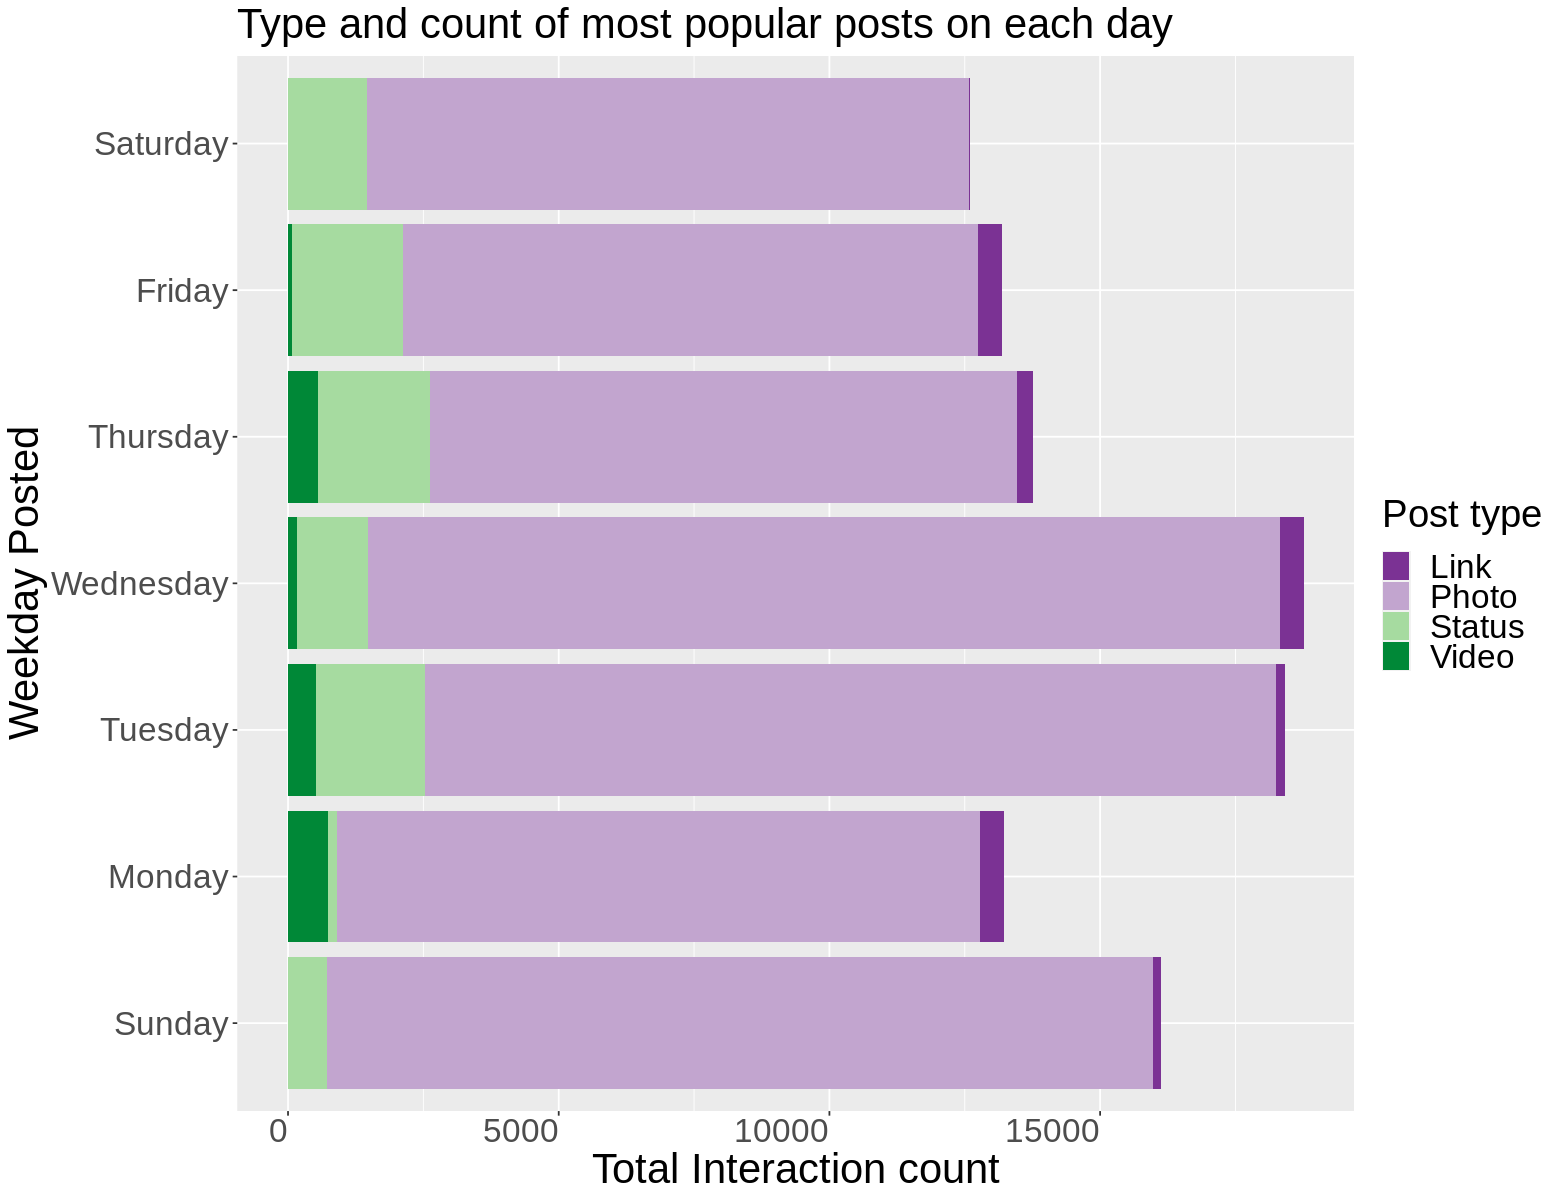

In [5]:
options(repr.plot.height = 10, repr.plot.width = 13)

most_interactions <- fb_data %>%                                      #plot of interactions and post type vs day
    arrange(desc(Post.Weekday)) %>%
    ggplot(aes(x = Post.Weekday, 
                 y = Total.Interactions,                     
                 fill = Type)) + 
    geom_bar(stat = "identity") +                                     #graph titles
    xlab("Weekday Posted") +
    ylab("Total Interaction count") +
    labs(fill = "Post type") +
    ggtitle("Type and count of most popular posts on each day") +
    theme(axis.text = element_text(size = 20,                         #font sizes
                                    hjust = 1),
         plot.title = element_text(size = 25),
         axis.title = element_text(size = 25),
         legend.text = element_text(size = 20),
         legend.title = element_text(size = 23)) +
            scale_fill_brewer(palette = 'PRGn') +
 scale_x_discrete(limits=c("1", "2", "3", "4", "5", "6", "7"),
                  labels=c("1" = "Sunday",
                           "2" = "Monday",
                           "3" = "Tuesday",
                           "4" = "Wednesday",
                           "5" = "Thursday",
                           "6" = "Friday",
                           "7" = "Saturday" )) +
    coord_flip()
most_interactions

# Methods:
* Explain how you will conduct either your data analysis and which variables/columns you will use. Note - you do not need to use all variables/columns that exist in the raw data set. In fact, that's often not a good idea. For each variable think: is this a useful variable for prediction?
> * We will conduct our data analysis by comparing the "Total Interaction Count" of each day which is divided and color-coded by the "Post Type."
> * We will use the Type, Total Interactions and Post Weekday columns as these will be useful in predicting which day and what type of post is most popular. 
* Describe at least one way that you will visualize the results
> * Color-coded bar graph with the x-axis being the "Total Interaction Count" (likes, shares, comments), and the y-axis as the "Weekday Posted." The "Post Type" being color-coded. 
> * Stacked bar graph with each color a different type of post(link, status, photo, video).

# Expected outcomes and significance:

* What do you expect to find?
> * Find the most interacted type of post and what day the most users are on each post. Based on the visualization titled Type and count of most popular posts on each day, we can see that Wednesday is the most populated day on Facebook where most of the users are interacting with a photo post.
* What impact could such findings have?
> * It would influence businesses who post often or want a following on their facebook page to plan what day and type of post they are going to use. Timing when to post to maximize engagement would help in broadening a brands reach by learning what kind of content is effective.
* What future questions could this lead to?
> * To increase interaction and active users on your account/posts, what kind of post should I use? What day should I post it? Is this data of Facebook going to be similar to other social media? WQould this data differ when the audience is aware that the post is an advertisement/promotion?

Sources: (Moro et al., 2016) Moro, S., Rita, P., & Vala, B. (2016). Predicting social media performance metrics and evaluation of the impact on brand building: A data mining approach. Journal of Business Research, 69(9), 3341-3351.

